# IoT Network Traffic Classification with Neural Networks

## Introduction
In this notebook, we will explore the process of classifying Internet of Things (IoT) network traffic using neural networks. IoT devices are becoming increasingly prevalent in various domains, ranging from smart homes to industrial automation. However, the proliferation of these devices also raises concerns about security, as they can be vulnerable to cyber attacks.

One approach to enhance IoT security is by analyzing network traffic to detect and classify malicious behavior. In this project, we will develop a neural network model that can classify IoT network traffic into different categories, such as benign and malicious.

## Dataset
We will use the IoT-23 dataset, which contains labeled network traffic captures from both benign and malicious IoT devices. This dataset was created as part of the Avast AIC laboratory with the funding of Avast Software. It includes various features extracted from network traffic, such as source and destination IP addresses, port numbers, network protocols, and more.

## Dataset Preparation

Before training our neural network model, we need to prepare our dataset. This involves splitting it into training, validation, and test sets, as well as separating features from labels.

### Dataset Splitting

We'll use the `train_val_test_split` function to split our dataset into training, validation, and test sets. This function allows us to control the randomness of the split and optionally perform a stratified split if we specify a stratification column.

In [1]:
from sklearn.model_selection import train_test_split

# Define the train_val_test_split function
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

## Feature and Label Separation

We'll use the `remove_labels` function to separate features from labels in each dataset.

In [2]:
# Define the remove_labels function
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

## Data Loading and Concatenation

To prepare our dataset for training, we need to load data from multiple CSV files and combine them into a single DataFrame.

### Loading Data from CSV Files

The IoT-23 dataset consists of twenty-three captures (scenarios) of different IoT network traffic. These scenarios are divided into twenty network captures from infected IoT devices, each named after the malware sample executed on the scenario, and three network captures of real IoT devices' network traffic.

We will use the `pandas` library to read data from CSV files located in a specified directory. Each CSV file represents a portion of our dataset.


In [3]:
import pandas as pd
import os

# Directory where your CSV files are located
directory = 'data'

# List to store all the DataFrames from CSV files
dfs = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read the CSV file and append it to the list of DataFrames
        df = pd.read_csv(os.path.join(directory, filename), delimiter='|')
        dfs.append(df)
        # Print the filename and the number of records in the DataFrame
        print(f"Processed file: {filename}")
        print(f"Number of records: {len(df)}\n")

# Calculate the total number of records in all files
total_records = sum(len(df) for df in dfs)

# Print the total number of files processed and the total number of records
print(f"Number of files: {len(dfs)}\n")
print(f"Total number of records: {total_records}\n")

Processed file: CTU-IoT-Malware-Capture-60-1conn.log.labeled.csv
Number of records: 32357

Processed file: CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv
Number of records: 4426

Processed file: CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv
Number of records: 275018

Processed file: CTU-IoT-Malware-Capture-8-1conn.log.labeled.csv
Number of records: 10403

Processed file: CTU-IoT-Malware-Capture-44-1conn.log.labeled.csv
Number of records: 237

Processed file: CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv
Number of records: 103463

Processed file: CTU-IoT-Malware-Capture-48-1conn.log.labeled.csv
Number of records: 33720

Processed file: CTU-IoT-Malware-Capture-20-1conn.log.labeled.csv
Number of records: 3209

Processed file: CTU-IoT-Malware-Capture-3-1conn.log.labeled.csv
Number of records: 156103

Processed file: CTU-IoT-Malware-Capture-9-1conn.log.labeled.csv
Number of records: 180027

Processed file: CTU-IoT-Malware-Capture-21-1conn.log.labeled.csv
Number of records: 3286

Proc

## Combining DataFrames

After loading data from all CSV files, we will combine them into a single DataFrame using the `pd.concat()` function.

In [4]:
# Combine all the DataFrames into one
final_df = pd.concat(dfs, ignore_index=True)

## Summary

Finally, let's print some summary statistics about our combined dataset.

In [5]:
print("Number of features:", len(final_df.columns))
print("Length of the dataset:", len(final_df))

Number of features: 23
Length of the dataset: 825394


In [6]:
final_df.head(200)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.568940e+09,CEjjLs1iwWYrt8C4O6,192.168.1.195,123.0,212.111.30.190,123.0,udp,-,0.008239,96,...,-,0.0,Dd,2.0,152.0,2.0,152.0,-,Benign,-
1,1.568940e+09,CHNzmm3tMu5Gse9Zvg,192.168.1.195,123.0,89.221.218.101,123.0,udp,-,0.007496,96,...,-,0.0,Dd,2.0,152.0,2.0,152.0,-,Benign,-
2,1.568940e+09,CDlbowGNUwsHckADd,192.168.1.195,37120.0,102.165.48.81,17769.0,tcp,-,1.848549,518,...,-,0.0,ShAdfDr,10.0,1572.0,8.0,540.0,-,Malicious C&C,HeartBeat
3,1.568940e+09,CxKxhj4MGsf5GcqoX6,192.168.1.1,47805.0,192.168.1.195,22.0,tcp,-,206.663644,2768,...,-,0.0,DdAaFf,400.0,26336.0,268.0,36368.0,-,Benign,-
4,1.568940e+09,C2n3PK3bA92hAgTHda,192.168.1.195,37122.0,102.165.48.81,17769.0,tcp,-,1.902519,518,...,-,0.0,ShAdfDr,10.0,1572.0,8.0,540.0,-,Malicious C&C,HeartBeat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.568956e+09,Cn4V6RtWlZIdKdGpk,192.168.1.195,123.0,81.2.254.32,123.0,udp,-,0.005499,96,...,-,0.0,Dd,2.0,152.0,2.0,152.0,-,Benign,-
196,1.568956e+09,CdA7KF34uLtWMdifE1,192.168.1.195,123.0,212.111.30.190,123.0,udp,-,0.008248,96,...,-,0.0,Dd,2.0,152.0,2.0,152.0,-,Benign,-
197,1.568956e+09,COSuFe3xcOcWLhs3Ch,192.168.1.195,123.0,89.221.218.101,123.0,udp,-,0.007498,96,...,-,0.0,Dd,2.0,152.0,2.0,152.0,-,Benign,-
198,1.568956e+09,CJxYkmmazUFacc5Af,192.168.1.195,123.0,89.221.210.188,123.0,udp,-,0.004497,96,...,-,0.0,Dd,2.0,152.0,2.0,152.0,-,Benign,-


## Understanding the Dataset

Before proceeding further, let's take a closer look at the combined dataset `final_df` using the `info()` method. This method provides a concise summary of the DataFrame, including information about the columns, their data types, and any missing values. Understanding the structure of the dataset is essential for preprocessing and analysis tasks.

This command will display information such as the total number of entries, the data type of each column, and the number of non-null values. It will help us gain insights into the dataset's overall composition and identify any potential issues that need to be addressed during data preprocessing.

In [7]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825394 entries, 0 to 825393
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ts              825394 non-null  float64
 1   uid             825394 non-null  object 
 2   id.orig_h       825394 non-null  object 
 3   id.orig_p       825394 non-null  float64
 4   id.resp_h       825393 non-null  object 
 5   id.resp_p       825392 non-null  float64
 6   proto           825392 non-null  object 
 7   service         825391 non-null  object 
 8   duration        825391 non-null  object 
 9   orig_bytes      825391 non-null  object 
 10  resp_bytes      825391 non-null  object 
 11  conn_state      825390 non-null  object 
 12  local_orig      825390 non-null  object 
 13  local_resp      825389 non-null  object 
 14  missed_bytes    825389 non-null  float64
 15  history         825389 non-null  object 
 16  orig_pkts       825389 non-null  float64
 17  orig_ip_by

## Descriptive Statistics

Understanding the distribution and summary statistics of the dataset's numerical features can provide valuable insights into its characteristics. We can use the `describe()` method to generate summary statistics for numerical columns.

In [8]:
final_df.describe()

,ts,id.orig_p,id.resp_p,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,8.253940e+05,825394.000000,825392.000000,825389.000000,8.253890e+05,8.253890e+05,825389.000000,825389.000000
mean,1.533564e+09,41973.450439,9370.371872,0.221911,3.104560e+02,1.351243e+04,0.290124,38.585079
std,1.064245e+07,14854.275109,19199.618576,45.584556,9.565734e+04,3.769722e+06,19.589784,1416.814555
min,1.525880e+09,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.525958e+09,36648.000000,23.000000,0.000000,1.000000e+00,4.000000e+01,0.000000,0.000000
50%,1.526869e+09,43763.000000,23.000000,0.000000,1.000000e+00,6.000000e+01,0.000000,0.000000
75%,1.533109e+09,52127.000000,8080.000000,0.000000,3.000000e+00,1.800000e+02,0.000000,0.000000
max,1.569018e+09,65535.000000,65535.000000,20272.000000,6.602735e+07,1.914793e+09,9307.000000,388975.000000


This command will display descriptive statistics such as count, mean, standard deviation, minimum, 25th percentile (Q1), median (50th percentile or Q2), 75th percentile (Q3), and maximum for each numerical column. These statistics help us understand the central tendency, dispersion, and shape of the numerical data distribution.

## Class Distribution

In classification tasks, it's essential to examine the distribution of classes to understand the balance or imbalance between different categories. We can use the `value_counts()` method on the target variable (e.g., `"label"`) to count the occurrences of each class.

In [9]:
final_df["label"].value_counts()

label
Malicious                                487946
Benign                                   250489
Malicious   DDoS                          46195
Malicious   PartOfAHorizontalPortScan     33765
Malicious   C&C                            6959
Malicious   Attack                           32
Malicious   FileDownload                      3
Name: count, dtype: int64

This command will return a series containing the counts of unique values in the target variable. Analyzing the class distribution helps in assessing the dataset's suitability for classification tasks and guides the selection of appropriate evaluation metrics.

## Data Processing

In this section, we'll preprocess the dataset to handle missing or undefined data effectively.

### Replace Hyphens with NA Values

We'll replace hyphens `('-')` with Pandas' `NA` values to better handle missing or undefined data.

In [10]:
final_df.replace('-', pd.NA, inplace=True)

### Check for Null Values

We'll check for null values in the dataset and print the count of null values for each column.

In [11]:
null_values = final_df.isnull().sum()
print(null_values)

ts                     0
uid                    0
id.orig_h              0
id.orig_p              0
id.resp_h              1
id.resp_p              2
proto                  2
service           812105
duration          577632
orig_bytes        577632
resp_bytes        577632
conn_state             4
local_orig        825394
local_resp        825394
missed_bytes           5
history             8276
orig_pkts              5
orig_ip_bytes          5
resp_pkts              5
resp_ip_bytes          5
tunnel_parents    825394
label                  5
detailed-label    337289
dtype: int64


### Visualize Null Values

 We'll visualize the null values using both bar plots and heatmaps to gain insights into the distribution of missing data.

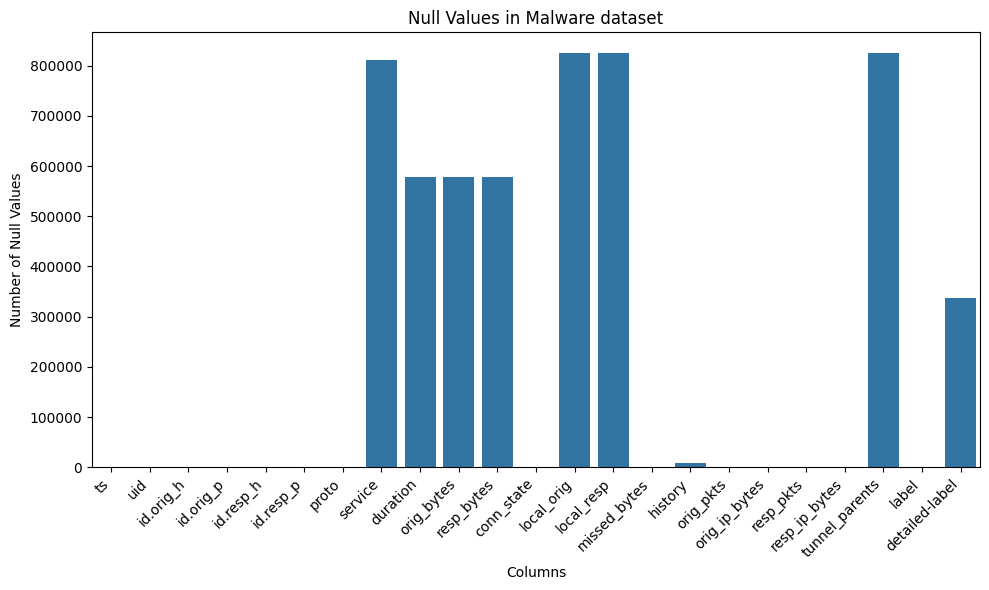

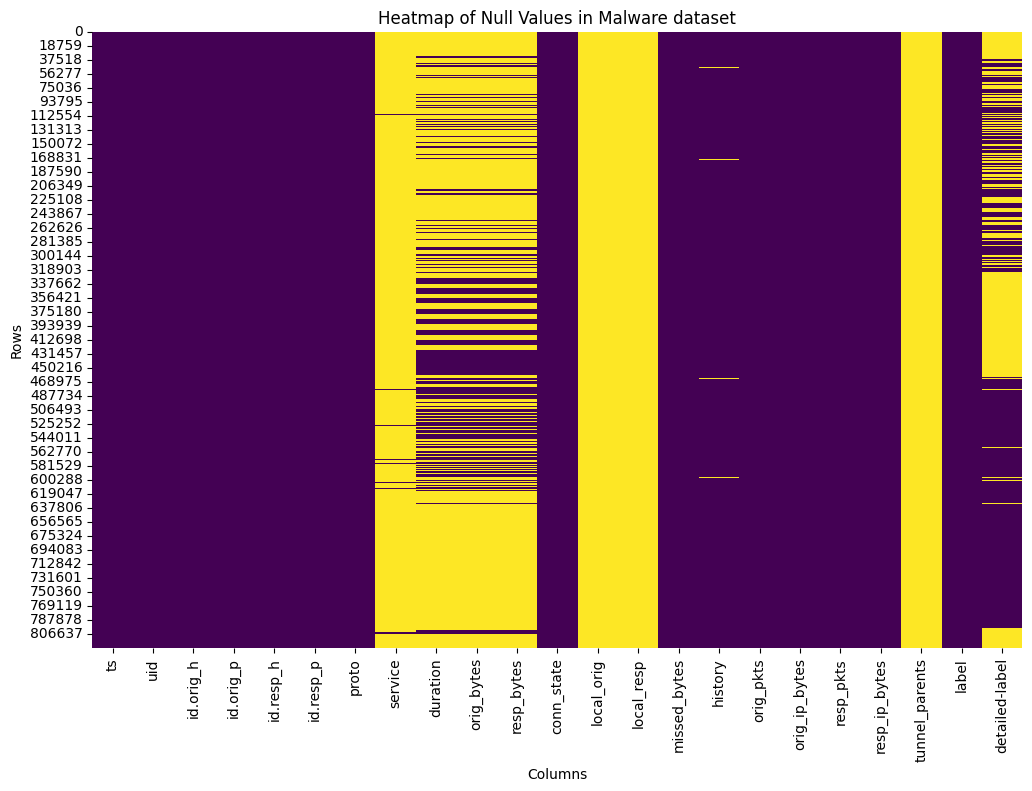

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting null values using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=null_values.index, y=null_values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.title('Null Values in Malware dataset')
plt.tight_layout()
plt.show()

# Generate a heatmap of null values
plt.figure(figsize=(12, 8))
sns.heatmap(final_df.isnull(), cmap='viridis', cbar=False)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Heatmap of Null Values in Malware dataset')
plt.show()

### Columns with Null Values

We'll identify columns with null values and print their percentages.

In [13]:
null_values = final_df.isnull().sum()
null_percentage = (null_values / len(final_df)) * 100
columns_with_null = null_percentage[null_percentage > 0]
print("Columns with Null Values (Percentage):")
print(columns_with_null)

Columns with Null Values (Percentage):
id.resp_h           0.000121
id.resp_p           0.000242
proto               0.000242
service            98.389981
duration           69.982578
orig_bytes         69.982578
resp_bytes         69.982578
conn_state          0.000485
local_orig        100.000000
local_resp        100.000000
missed_bytes        0.000606
history             1.002673
orig_pkts           0.000606
orig_ip_bytes       0.000606
resp_pkts           0.000606
resp_ip_bytes       0.000606
tunnel_parents    100.000000
label               0.000606
detailed-label     40.863999
dtype: float64


### Drop Columns with Null Values

Finally, we'll drop columns with a significant number of null values to clean up the dataset.

In [14]:
final_df.drop(['service', 'orig_bytes', 'resp_bytes', 'local_orig', 'local_resp', 'tunnel_parents', 'duration', 'ts', 'detailed-label', 'uid', 'missed_bytes'], axis=1, inplace=True)

### Drop Rows with Null Values in Specific Column

We'll also drop rows with null values in the `'history'` column.

In [15]:
final_df.dropna(subset=['history'], inplace=True)

### Drop Rows with Null Label Values

We drop rows with null label values to ensure that each sample in the dataset is labeled properly.

In [16]:
final_df = final_df.dropna(subset=['label'])

### Data Cleaning and Transformation

We update label values for consistency and clarity. For example, we replace 'Malicious DDo' with 'Malicious DDoS' to correct a typo and merge similar attack types under the 'Malicious' category.

In [17]:
replacement_dict = {
    'Malicious   DDo': 'Malicious   DDoS',
    'Malicious   FileDownload': 'Malicious',
    'Malicious   Attack': 'Malicious',
    'M': 'Malicious',
    'Ma': 'Malicious',
    'Malicious   PartOfAHorizontal': 'Malicious   PartOfAHorizontalPortScan'
}

final_df['label'] = final_df['label'].replace(replacement_dict)

### Exploratory Data Analysis (EDA)

We visualize the distribution of attacks in the dataset to gain insights into the prevalence of different attack types.

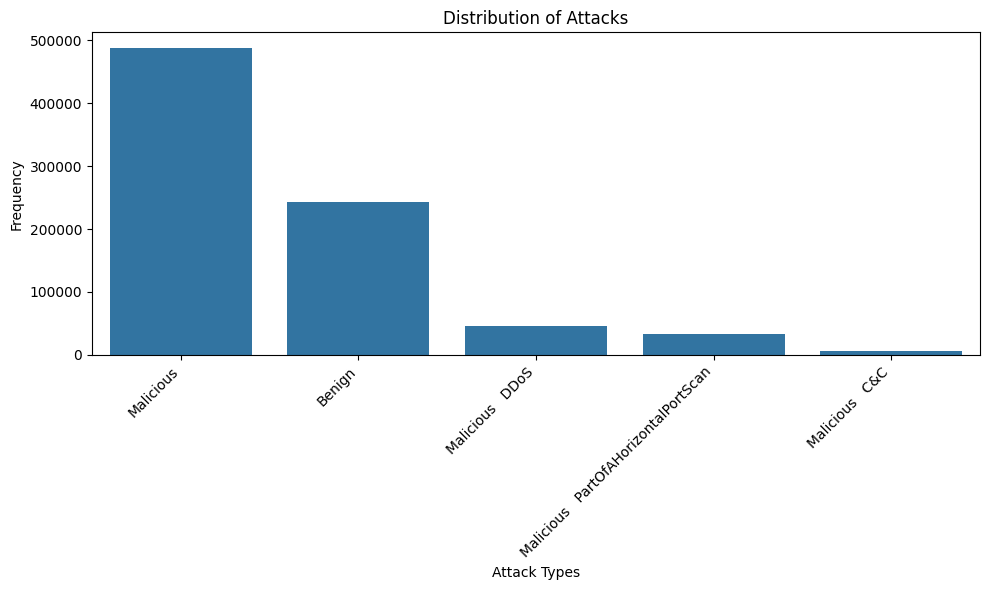

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of attacks using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=final_df["label"].value_counts().index, y=final_df["label"].value_counts().values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Attack Types')
plt.ylabel('Frequency')
plt.title('Distribution of Attacks')
plt.tight_layout()
plt.show()

### Displaying the Processed Dataset

Finally, after performing the necessary preprocessing steps, it's beneficial to inspect the resulting dataset to ensure that the desired transformations have been applied correctly.

In [19]:
final_df

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,conn_state,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,192.168.1.195,123.0,212.111.30.190,123.0,udp,SF,Dd,2.0,152.0,2.0,152.0,Benign
1,192.168.1.195,123.0,89.221.218.101,123.0,udp,SF,Dd,2.0,152.0,2.0,152.0,Benign
2,192.168.1.195,37120.0,102.165.48.81,17769.0,tcp,RSTR,ShAdfDr,10.0,1572.0,8.0,540.0,Malicious C&C
3,192.168.1.1,47805.0,192.168.1.195,22.0,tcp,SF,DdAaFf,400.0,26336.0,268.0,36368.0,Benign
4,192.168.1.195,37122.0,102.165.48.81,17769.0,tcp,RSTR,ShAdfDr,10.0,1572.0,8.0,540.0,Malicious C&C
...,...,...,...,...,...,...,...,...,...,...,...,...
825389,192.168.1.195,57110.0,185.244.25.235,6667.0,tcp,S3,ShAdDaf,7.0,434.0,6.0,589.0,Malicious C&C
825390,192.168.1.195,57092.0,185.244.25.235,6667.0,tcp,S3,ShAdDaf,10.0,606.0,7.0,632.0,Malicious C&C
825391,192.168.1.195,123.0,147.251.48.140,123.0,udp,S0,D,1.0,76.0,0.0,0.0,Benign
825392,192.168.1.195,123.0,82.113.53.40,123.0,udp,S0,D,1.0,76.0,0.0,0.0,Benign


This command displays the processed DataFrame, showing the effect of the preprocessing steps performed earlier.

### Encoding Categorical Features

Categorical features in the dataset need to be encoded into numerical representations before they can be used in machine learning models. One common approach is to use Label Encoding for categorical features, where each unique category is assigned a numerical label. Similarly, IP addresses need to be transformed into numerical representations.

In [20]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import pandas as pd
import joblib

# Hashing IP addresses
columns_to_hash = ['id.orig_h', 'id.resp_h']
for column in columns_to_hash:
    final_df[column] = final_df[column].apply(hash)

# Encoding categorical columns with LabelEncoder
categorical_columns_to_label_encoder = ['proto', 'conn_state', 'history']
for column in categorical_columns_to_label_encoder:
    print("column", column)
    # Initialize LabelEncoder
    categorical_label_encoder = LabelEncoder()
    # Fit and transform the column
    final_df[column] = categorical_label_encoder.fit_transform(final_df[column])
    # Save the LabelEncoder object for future use
    filename = f'categorical_label_encoder_{column}.pkl'
    joblib.dump(categorical_label_encoder, filename)
    # Print the classes encoded by LabelEncoder
    print("Categorical columns labels for", column, ":", categorical_label_encoder.classes_)

# Convert certain columns to numeric data types
final_df['id.orig_p'] = pd.to_numeric(final_df['id.orig_p'])
final_df['id.resp_p'] = pd.to_numeric(final_df['id.resp_p'])
final_df['orig_ip_bytes'] = pd.to_numeric(final_df['orig_ip_bytes'])
final_df['resp_pkts'] = pd.to_numeric(final_df['resp_pkts'])
final_df['resp_ip_bytes'] = pd.to_numeric(final_df['resp_ip_bytes'])


column proto
Categorical columns labels for proto : ['tcp' 'udp']
column conn_state
Categorical columns labels for conn_state : ['OTH' 'REJ' 'RSTO' 'RSTOS0' 'RSTR' 'RSTRH' 'S0' 'S1' 'S2' 'S3' 'SF' 'SH'
 'SHR']
column history
Categorical columns labels for history : ['Aa' 'C' 'CCC' 'CCCC' 'D' 'DAd' 'DFafA' 'D^' 'D^d' 'DaFfA' 'Dd' 'DdA'
 'DdAa' 'DdAaFf' 'DdAtaFf' 'F' 'R' 'S' 'SAD' 'SaR' 'SahAdDF' 'SahAdDFRf'
 'SahAdDFf' 'SahAdDtFf' 'ShA' 'ShAD' 'ShADCaGcgd' 'ShADCaGdfF' 'ShADF'
 'ShADFa' 'ShADFaR' 'ShADFadfR' 'ShADFadfRR' 'ShADFar' 'ShADFfR' 'ShADFfa'
 'ShADFr' 'ShADa' 'ShADaCGcgdF' 'ShADaCGdt' 'ShADaCGdtfF' 'ShADaCGr'
 'ShADaF' 'ShADaR' 'ShADacdtfF' 'ShADad' 'ShADadFf' 'ShADadFfR' 'ShADadR'
 'ShADadRf' 'ShADadf' 'ShADadfF' 'ShADadfR' 'ShADadfrr' 'ShADadtFf'
 'ShADadtcfF' 'ShADadtctfF' 'ShADadtctfFR' 'ShADadtfF' 'ShADadttFf'
 'ShADadttcfF' 'ShADadttfF' 'ShADafF' 'ShADafr' 'ShADarfF' 'ShADda'
 'ShADdaf' 'ShADdafR' 'ShADdfFa' 'ShADfdtR' 'ShADr' 'ShADrfR' 'ShAF'
 'ShAFa' 'ShAFf' 'ShAFr' 'Sh

In this code snippet:

- The categorical columns in the DataFrame `final_df` are converted to string type to ensure uniformity.
- IP addresses in specified columns are hashed using a simple hash function to convert them into numerical representations while maintaining anonymity.
- Then, a `LabelEncoder` is applied to each categorical column, transforming the categorical values into numerical labels.
- The resulting numerical labels for categorical columns are saved as individual files using joblib for future use.
- Certain numerical columns like 'id.orig_p', 'id.resp_p', 'orig_ip_bytes', 'resp_pkts', and 'resp_ip_bytes' are converted to numeric data type using Pandas' `pd.to_numeric` function to ensure consistency in data type across the dataset.

### Splitting the Dataset

Before training a machine learning model, it's common practice to split the dataset into training, validation, and test sets. This helps in evaluating the model's performance on unseen data.

In [21]:
train_set, val_set, test_set = train_val_test_split(final_df)

X_train, y_train = remove_labels(train_set, 'label')
X_val, y_val = remove_labels(val_set, 'label')
X_test, y_test = remove_labels(test_set, 'label')

In this code:

- The `final_df` dataset is split into training, validation, and test sets using the `train_val_test_split` function.
- The features (X) and labels (y) are separated from each dataset.

### Encoding Categorical Labels and One-Hot Encoding

In machine learning, it's common to work with categorical labels that need to be encoded into numerical form before feeding them into a model. Additionally, for classification tasks with multiple classes, it's beneficial to represent these encoded labels as one-hot encoded vectors. This section demonstrates how to perform label encoding and one-hot encoding using scikit-learn's `LabelEncoder` and Keras's `to_categorical` functions.

In [22]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode labels in y_train using LabelEncoder
y_train_encoded = label_encoder.fit_transform(y_train)

# Get unique labels
unique_labels = label_encoder.classes_
print("y_train_encoded Unique labels:", unique_labels)

# Convert encoded labels to one-hot vectors
y_train_encoded = to_categorical(y_train_encoded, num_classes=len(unique_labels))
print("Encoded y_train:", y_train_encoded)

# Encode labels in y_val using the new LabelEncoder instance
y_val_encoded = label_encoder.transform(y_val)
print("Encoded y_val:", y_val_encoded)

# Convert encoded labels to one-hot vectors
y_val_encoded = to_categorical(y_val_encoded, num_classes=len(unique_labels))
print("Encoded y_val:", y_val_encoded)

# Encode labels in y_test using the new LabelEncoder instance
y_test_encoded = label_encoder.transform(y_test)
print("Encoded y_test:", y_test_encoded)

# Convert encoded labels to one-hot vectors
y_test_encoded = to_categorical(y_test_encoded, num_classes=len(unique_labels))
print("Encoded y_test:", y_test_encoded)

y_train_encoded Unique labels: ['Benign' 'Malicious' 'Malicious   C&C' 'Malicious   DDoS'
 'Malicious   PartOfAHorizontalPortScan']
Encoded y_train: [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Encoded y_val: [1 1 0 ... 0 0 1]
Encoded y_val: [[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Encoded y_test: [4 1 1 ... 0 1 1]
Encoded y_test: [[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [23]:
import joblib

joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

**Explanation:**

- **Label Encoding:** The **`LabelEncoder`** is used to transform categorical labels into numerical representations. Each unique label is assigned a unique integer.
- **Handling Missing Values:** Rows with missing labels are dropped using **`dropna`** to maintain data integrity.
- **Fitting LabelEncoder:** The **`fit_transform`** method of **`LabelEncoder`** is used to fit and transform the training labels (`y_train`) into encoded form.
- **Unique Labels:** The **`classes_`** attribute of **`LabelEncoder`** provides the unique labels in alphabetical order.
- **One-Hot Encoding:** The **`to_categorical`** function from Keras is used to convert the encoded labels into one-hot encoded vectors. Each integer label is converted into a binary vector, where the index corresponding to the label is set to 1 and all other indices are set to 0.
- **Encoding Validation and Test Sets:** The same **`LabelEncoder`** instance is used to transform the validation (**`y_val`**) and test (**`y_test`**) labels into encoded form. Then, these encoded labels are converted into one-hot encoded vectors in a similar manner.

This process ensures that the categorical labels are appropriately encoded and transformed into a format suitable for training classification models, such as neural networks.

### Data Standardization with StandardScaler

Data standardization is a preprocessing technique used to transform the features of a dataset to have a mean of 0 and a standard deviation of 1. This process ensures that the features are on the same scale, which is essential for many machine learning algorithms, particularly those based on **distance metrics or gradient descent optimization**.

In [24]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler to normalize the input data
scaler = StandardScaler()

# Normalize the training data (X_train)
X_train_scaled = scaler.fit_transform(X_train)

# Normalize the validation data (X_val) using the same scaler instance
X_val_scaled = scaler.transform(X_val)

# Normalize the test data (X_test) using the same scaler instance
X_test_scaled = scaler.transform(X_test)

In [25]:
import joblib

joblib.dump(scaler, 'standard_scaler.pkl')

['standard_scaler.pkl']

In [26]:
X_train_scaled

array([[-9.17625965e-01,  1.11325484e+00, -4.27888533e-01, ...,
        -3.12855609e-03,  3.12375990e-02,  1.29137266e-03],
       [ 9.76083549e-01,  9.56160374e-02,  1.46821118e+00, ...,
        -3.13350379e-03, -1.41298098e-02, -2.79914298e-02],
       [ 9.76083549e-01,  9.62555670e-01,  8.00875613e-01, ...,
        -3.12855609e-03, -1.41298098e-02, -2.79914298e-02],
       ...,
       [ 9.76083549e-01,  9.56160374e-02,  8.52778911e-01, ...,
        -3.13350379e-03, -1.41298098e-02, -2.79914298e-02],
       [ 5.51542449e-01, -1.56095651e+00,  1.20726715e+00, ...,
        -3.13350379e-03, -1.41298098e-02, -2.79914298e-02],
       [ 9.76083549e-01,  1.28597175e+00, -1.59111264e-01, ...,
        -3.12855609e-03, -1.41298098e-02, -2.79914298e-02]])

**Explanation:**

- **StandardScaler Initialization:** The StandardScaler class from scikit-learn is used to perform standardization. It standardizes features by removing the mean and scaling them to unit variance.
- **Fitting and Transforming:** The fit_transform method of StandardScaler is used to compute the mean and standard deviation of the training data (X_train) and then apply the transformation to standardize the features.
For validation and test datasets (X_val and X_test), the transform method is used to apply the same transformation learned from the training data.
- **Consistency Across Sets:** It's crucial to use the same scaler instance (scaler) to normalize all datasets (training, validation, and test) to ensure consistency in scaling across different sets.
- **Data Normalization Benefits:** Normalizing the input data helps improve the convergence speed of gradient-based optimization algorithms, reduces the sensitivity to the scale of features, and often leads to better performance of machine learning models.

By standardizing the input features, we ensure that each feature contributes equally to the model's learning process, leading to better overall performance and stability during training.

### Neural Network with Dropout

In this section, we'll explore the implementation of a neural network model that incorporates dropout layers. These techniques are commonly used to improve the performance and generalization of deep learning models.

#### Dropout:

Dropout is a regularization technique used to prevent overfitting by randomly dropping a fraction of the neurons during training. It helps in improving the generalization performance of the model by reducing the co-adaptation of neurons.

- **Implementation**: Dropout layers are added after each batch normalization layer in the model. They randomly deactivate a fraction of the neurons in the previous layer during each training iteration, forcing the network to learn more robust features.

#### Model Architecture:

The neural network model consists of input, hidden, and output layers:

- **Input Layer**: An input layer with the shape corresponding to the number of features in the input data.

- **Hidden Layers**: Multiple dense layers with batch normalization, activation functions (ReLU), and dropout. These layers capture the complex relationships in the data and prevent overfitting.

- **Output Layer**: A dense output layer with a softmax activation function, which produces probabilities for each class in a multi-class classification task.

#### Compilation:

The model is compiled with the Adam optimizer, categorical cross-entropy loss function, and evaluation metrics including accuracy and precision.

#### Benefits:
  
- **Preventing Overfitting**: Dropout layers prevent overfitting by randomly deactivating neurons, forcing the network to learn more generalizable features.
  
- **Better Generalization**: Using dropout can lead to better generalization performance on unseen data.

By incorporating dropout layers into the model architecture, you can build more robust and efficient deep learning models for various tasks.


In [27]:
from tensorflow.keras import models, layers, regularizers

model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(X_train_scaled.shape[1],)))

# Hidden layers
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy', 'Precision'])


### Model Summary

The `model.summary()` function provides a concise overview of the architecture and parameters of the neural network model. It displays the layers, their output shapes, and the number of parameters in each layer. This summary is useful for understanding the structure of the model and verifying its correctness.


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               6144      
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

After building the neural network model, calling `model.summary()` prints a summary table in the console or notebook output. This table includes information about each layer, such as the layer type, output shape, and number of trainable parameters.

### Training with Early Stopping

During model training, the `fit()` method is called with the training data, validation data, and other parameters including the number of epochs and batch size. The `callbacks` parameter is used to specify additional callbacks, such as early stopping.

- **Preventing Overfitting**: Early stopping helps prevent overfitting by stopping the training process when the model's performance on the validation set no longer improves.
  
- **Optimizing Training Time**: Early stopping can reduce training time by stopping the training process once the model has converged to its optimal performance.

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_scaled,
                    y_train_encoded,
                    epochs=8,
                    batch_size=32,
                    validation_data=(X_val_scaled, y_val_encoded),
                    callbacks=[early_stopping])

Epoch 1/8
15321/15321 [==============================] - 134s 9ms/step - loss: 0.0798 - accuracy: 0.9914 - precision: 0.9915 - val_loss: 0.0641 - val_accuracy: 0.9955 - val_precision: 0.9955
Epoch 2/8
15321/15321 [==============================] - 141s 9ms/step - loss: 0.0784 - accuracy: 0.9914 - precision: 0.9916 - val_loss: 0.0643 - val_accuracy: 0.9957 - val_precision: 0.9957
Epoch 3/8
15321/15321 [==============================] - 143s 9ms/step - loss: 0.0793 - accuracy: 0.9913 - precision: 0.9914 - val_loss: 0.0666 - val_accuracy: 0.9953 - val_precision: 0.9953
Epoch 4/8
15321/15321 [==============================] - 137s 9ms/step - loss: 0.0823 - accuracy: 0.9913 - precision: 0.9914 - val_loss: 0.0772 - val_accuracy: 0.9918 - val_precision: 0.9919
Epoch 5/8
15321/15321 [==============================] - 141s 9ms/step - loss: 0.0799 - accuracy: 0.9913 - precision: 0.9915 - val_loss: 0.0653 - val_accuracy: 0.9956 - val_precision: 0.9956
Epoch 6/8
15321/15321 [======================

## Plotting Training History

### Loss vs. Epochs:

The first plot shows the training and validation loss over epochs. It provides insights into the model's convergence and whether it is overfitting or underfitting. A decreasing training loss indicates that the model is learning from the training data, while the validation loss indicates the model's performance on unseen data.

- **Implementation**: The training and validation loss data are extracted from the `history` object returned by the `fit()` method. These values are then plotted using `matplotlib.pyplot` to visualize the loss trends over epochs.

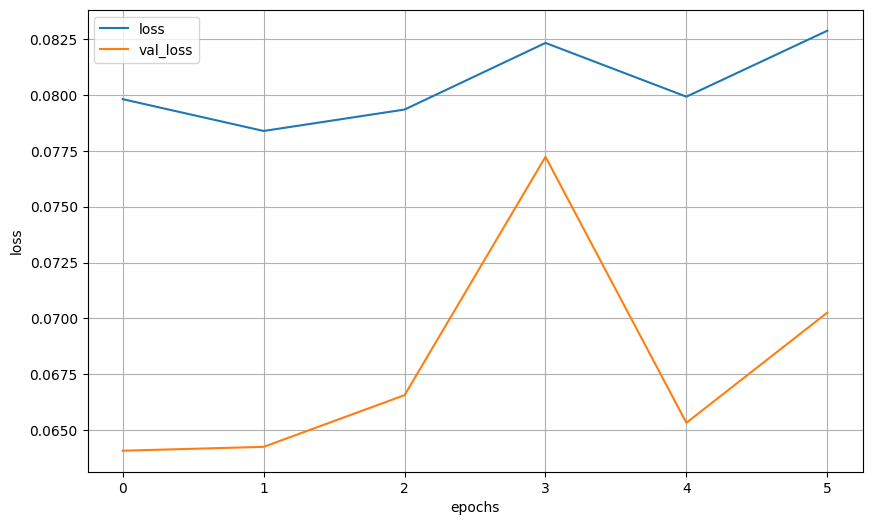

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Accuracy vs. Epochs

The second plot shows the training and validation accuracy over epochs. It helps assess how well the model is performing on both the training and validation datasets. An increasing accuracy indicates that the model is improving in its ability to correctly classify samples.

- **Implementation:** Similar to the loss plot, the training and validation accuracy data are extracted from the **`history`** object and plotted using **`matplotlib.pyplot.`**

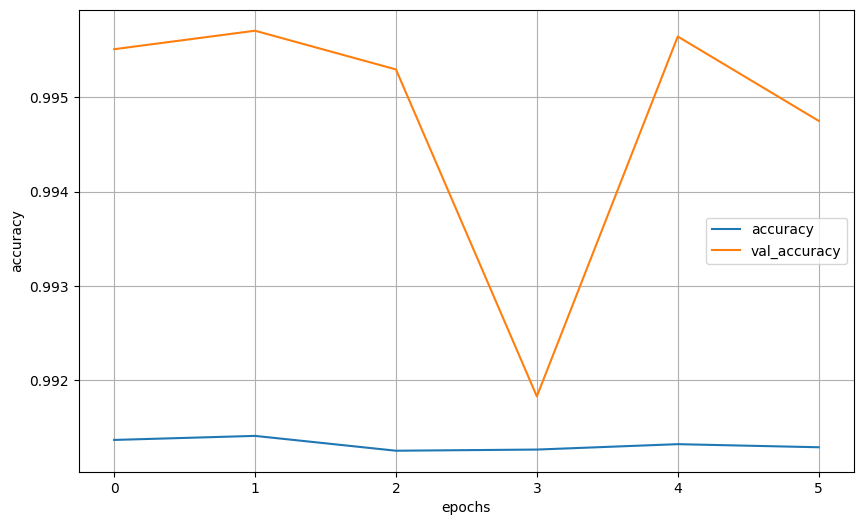

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()


- **Loss Plot:** Look for convergence of training and validation loss. If the training loss decreases but the validation loss starts to increase, it indicates overfitting.
- **Accuracy Plot:** Monitor the increase in accuracy over epochs. A large gap between training and validation accuracy may indicate overfitting.

These plots provide valuable insights into the training process and can help in tuning model hyperparameters.

## Model Evaluation

Once the model has been trained, it's crucial to evaluate its performance on a test dataset to understand how well it generalizes to unseen data. To do this, we use the evaluate function provided by the Keras API in TensorFlow.



In [33]:
error, accuracy, precision = model.evaluate(X_test_scaled, y_test_encoded)
print("Error: ", error)
print("Accuracy: ", accuracy)
print("Precision: ", precision)

5107/5107 [==============================] - 16s 3ms/step - loss: 0.0634 - accuracy: 0.9958 - precision: 0.9958
Error:  0.06335538625717163
Accuracy:  0.9958023428916931
Precision:  0.9958328008651733


- **Error:** It is the loss obtained by the model on the test dataset.
- **Accuracy:** It is the model's accuracy on the test dataset, i.e., the fraction of samples classified correctly.
- **Precision:** It is a measure of the model's precision in predicting positive samples relative to all samples predicted as positive.

These values provide us with a quantitative understanding of the model's performance and help us determine its effectiveness in the classification task.

## Saving the Trained Model and Weights

After training a deep learning model, it's essential to save both the model architecture and its trained weights for future use or deployment. We can achieve this in TensorFlow using the **`save`** method provided by the Keras API.

In [34]:
# Define the file paths for saving the model and weights
model_path = 'trained_model/model.h5'
weights_path = 'trained_model/weights.h5'

# Save the trained model architecture
model.save(model_path)

# Save the trained model weights
model.save_weights(weights_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


This code saves the entire model architecture to a single HDF5 file **(model.h5)** and the trained weights to another HDF5 file **(weights.h5)**. These files can then be loaded later to make predictions on new data or continue training the model.